# Astronomical Coordinates 1: Getting Started with astropy.coordinates

## Authors
Adrian Price-Whelan

## Learning Goals
* Create `astropy.coordinates.SkyCoord` objects using coordinate data and object names
* Use SkyCoord objects to become familiar with object oriented programming (OOP)
* Use a `SkyCoord` object to query the *Gaia* archive using `astroquery`
* Output coordinate data in different string representations
* Demonstrate working with 3D sky coordinates (including distance information for objects)

## Keywords
coordinates, OOP, astroquery, gaia


## Summary

Astronomers use a wide variety of coordinate systems and formats to represent sky coordinates of celestial objects. For example, you may have seen terms like "right ascension" and "declination" or "galactic latitude and longitude," and you may have seen angular coordinate components represented as "0h39m15.9s," "00:39:15.9," or 9.81625º. The subpackage `astropy.coordinates` provides tools for representing the coordinates of objects and transforming them between different systems. 

In this tutorial, we will explore how the `astropy.coordinates` package can be used to work with astronomical coordinates. You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link. 

*Note: This is the 1st tutorial in a series of tutorials about astropy.coordinates.*
- [Next tutorial: Astronomical Coordinates 2: Transforming Coordinate Systems and Representations](2-Coordinates-Transforms)

## Imports

We start by importing some packages that we will need below:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file

from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = 10000  # Set the row limit for returned data

## Representing On-sky Positions with `astropy.coordinates`

In Astropy, the most common way of representing and working with sky coordinates is to use the `SkyCoord` object ([docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)). A `SkyCoord` can be created directly from angles or arrays of angles with associated units, as demonstrated below. 

To get started, let's assume that we want to create a `SkyCoord` object for the center of the open star cluster NGC 188 so that later we can query and retrieve stars that might be members of the cluster. Let's also assume, for now, that we already know the sky coordinates of the cluster to be (12.11, 85.26) degrees in the ICRS coordinate frame. The ICRS — sometimes referred to as "equatorial" or "J2000" coordinates ([more info about the ICRS](https://arxiv.org/abs/astro-ph/0602086)) — is currently the most common astronomical coordinate frame for stellar or extragalactic astronomy, and is the default coordinate frame for `SkyCoord`. Since we already know the ICRS position of NGC 188 (see above), we can create a `SkyCoord` object for the cluster by passing the data in to the `SkyCoord` initializer:

In [2]:
ngc188_center = SkyCoord(12.11*u.deg, 85.26*u.deg)
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

Even though the default frame is ICRS, it is generally recommended to explicitly specify the frame your coordinates are in. In this case, this would be an equivalent way of creating our `SkyCoord` object for NGC 188:

In [3]:
ngc188_center = SkyCoord(12.11*u.deg, 85.26*u.deg, frame='icrs')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

As we will see later on in this series, there are many other supported coordinate frames, so it helps to get into the habit of passing in the name of a coordinate frame.

In the above initializations, we passed in `astropy.units.Quantity` objects with angular units to specify the angular components of our sky coordinates. The `SkyCoord` initializer will also accept string-formatted coordinates either as separate strings for Right Ascension (RA) and Declination (Dec) or a single string. For example, if we have sexagesimal sky coordinate data: In this case, the representation of the data includes specifications of the units (the "hms" for "hour minute second", and the "dms" for "degrees minute second"

In [4]:
SkyCoord('00h48m26.4s', '85d15m36s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

Some string representations do not explicitly define units, so it is sometimes necessary to specify the units of the string coordinate data explicitly if they are not implicitly included:

In [5]:
SkyCoord('00:48:26.4 85:15:36', unit=(u.hour, u.deg), 
         frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

For more information and examples on initializing `SkyCoord` objects, [see this documentation](http://docs.astropy.org/en/latest/coordinates/skycoord.html).

For the `SkyCoord` initializations demonstrated above, we assumed that we already had the coordinate component values ready. If you do not know the coordinate values and the object you are interested in is in [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), you can also automatically look up and load coordinate values from the name of the object using the `SkyCoord.from_name()` class method<sup>1</sup> ([docs](http://docs.astropy.org/en/latest/coordinates/index.html#convenience-methods)). Note, however, that this requires an internet connection. It is safe to skip this cell if you are not connected to the internet because we already defined the object `ngc188_center` in the cells above.

<sub> <sup>1</sup>If you do not know what a class method is, think of it like an alternative constructor for a `SkyCoord` object — calling `SkyCoord.from_name()` with a name gives you a new `SkyCoord` object. For more detailed background on what class methods are and when they're useful, see [this page](https://julien.danjou.info/blog/2013/guide-python-static-class-abstract-methods).</sub>

In [6]:
ngc188_center = SkyCoord.from_name('NGC 188')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (11.798, 85.244)>

The `SkyCoord` object that we defined now has various ways of accessing the coordinate information contained within it. All `SkyCoord` objects have attributes that allow you to retrieve the coordinate component data, but the component names will change depending on the coordinate frame of the `SkyCoord` you have. In our examples we have created a `SkyCoord` in the ICRS frame, so the component names are lower-case abbreviations of Right Ascension, `.ra`, and Declination, `.dec`:

In [7]:
ngc188_center.ra, ngc188_center.dec

(<Longitude 11.798 deg>, <Latitude 85.244 deg>)

The `SkyCoord` component attributes (here ``ra`` and ``dec``) return specialized `Quantity`-like objects that make working with angular data easier. While `Quantity` ([docs](http://docs.astropy.org/en/stable/units/index.html)) is a general class that represents numerical values and physical units of any kind, `astropy.coordinates` defines subclasses of `Quantity` that are specifically designed for working with angles, such as the `Angle` ([docs](http://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html)) class. The `Angle` class then has additional, more specialized subclasses `Latitude` ([docs](http://docs.astropy.org/en/stable/api/astropy.coordinates.Latitude.html)) and `Longitude` ([docs](http://docs.astropy.org/en/stable/api/astropy.coordinates.Longitude.html)). These objects store angles, provide useful attributes to quickly convert to common angular units, and enable formatting the numerical values in various formats. For example, in a Jupyter notebook, these objects know how to represent themselves using LaTeX:

In [8]:
ngc188_center.ra

<Longitude 11.798 deg>

In [9]:
ngc188_center.dec

<Latitude 85.244 deg>

In [10]:
type(ngc188_center.ra), type(ngc188_center.dec)

(astropy.coordinates.angles.Longitude, astropy.coordinates.angles.Latitude)

With these objects, we can retrieve the coordinate components in different units using the `Quantity.to()` method:

In [11]:
(ngc188_center.ra.to(u.hourangle), 
 ngc188_center.ra.to(u.radian),
 ngc188_center.ra.to(u.degree))

(<Longitude 0.78653333 hourangle>,
 <Longitude 0.20591395 rad>,
 <Longitude 11.798 deg>)

Or using the shorthand attributes, which return only the component values:

In [12]:
(ngc188_center.ra.hour, 
 ngc188_center.ra.radian, 
 ngc188_center.ra.degree)

(0.7865333333333335, 0.205913945150291, 11.798)

We can also format the values into strings with specified units ([docs](http://docs.astropy.org/en/latest/coordinates/formatting.html)), for example:

In [13]:
ngc188_center.ra.to_string(unit=u.hourangle, sep=':', pad=True)

'00:47:11.52'

## Querying the *Gaia* Archive to Retrieve Coordinates of Stars in NGC 188

Now that we have a `SkyCoord` object for the center of NGC 188, we can use this object with the `astroquery` package to query many different astronomical databases (see a full list of [available services in the astroquery documentation](https://astroquery.readthedocs.io/en/latest/#available-services)). Here, we will use the `SkyCoord` object `ngc188_center` to select sources from the *Gaia* Data Release 2 catalog around the position of the center of NGC 188 to look for stars that might be members of the star cluster. To do this, we will use the `astroquery.gaia` subpackage ([docs](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html)).

This requires an internet connection, but if it fails, the catalog file is included in the repository so you can load it locally (skip the next cell if you do not have an internet connection):

In [14]:
job = Gaia.cone_search_async(ngc188_center, radius=0.5*u.deg)
ngc188_table = job.get_results()

# only keep stars brighter than G=19 magnitude
ngc188_table = ngc188_table[ngc188_table['phot_g_mean_mag'] < 19*u.mag]

INFO: Query finished. [astroquery.utils.tap.core]


In [15]:
cols = [
    'source_id',
    'ra',
    'dec',
    'parallax',
    'parallax_error',
    'pmra',
    'pmdec',
    'radial_velocity',
    'phot_g_mean_mag',
    'phot_bp_mean_mag',
    'phot_rp_mean_mag'
]
ngc188_table[cols].write('gaia_results.fits', overwrite=True)

The above cell may not work if you do not have an internet connection, so we have included the results table along with the notebook:

In [16]:
ngc188_table = QTable.read('gaia_results.fits')

In [17]:
len(ngc188_table)

4954

The returned `astropy.table` `Table` object now contains about 5000 stars from *Gaia* DR2 around the coordinate position of the center of NGC 188. Let's now construct a `SkyCoord` object with the results table. In the *Gaia* data archive, the ICRS coordinates of a source are given as column names `"ra"` and `"dec"`:

In [18]:
ngc188_table['ra']

<Quantity [11.83026182, 11.77583526, 11.78143428, ...,  9.00733176,
            6.28374403, 16.03700724] deg>

In [19]:
ngc188_table['dec']

<Quantity [85.2436267 , 85.24193176, 85.24714789, ..., 84.81444405,
           85.08002617, 84.91080112] deg>

Note that, because the *Gaia* archive provides data tables with associated units, and we read this table using the `QTable` object ([docs](http://docs.astropy.org/en/latest/table/mixin_columns.html#quantity-and-qtable)), the above table columns are represented as `Quantity` objects with units of degrees. Note also that these columns contain many (>5000!) coordinate values. We can pass these directly in to `SkyCoord` to get a single `SkyCoord` object to represent all of these coordinates:

In [20]:
ngc188_gaia_coords = SkyCoord(ngc188_table['ra'], ngc188_table['dec'])
ngc188_gaia_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(11.83026182, 85.2436267 ), (11.77583526, 85.24193176),
     (11.78143428, 85.24714789), ..., ( 9.00733176, 84.81444405),
     ( 6.28374403, 85.08002617), (16.03700724, 84.91080112)]>

### Exercises

Create a `SkyCoord` for the center of the open cluster the Pleiades (either by looking up the coordinates and passing them in, or by using the convenience method we learned about above):

In [21]:
ngc188_center = SkyCoord.from_name('NGC 188')

Using only a single method/function call on the `SkyCoord` object representing the center of NGC 188, print a string with the RA/Dec in the form 'HH:MM:SS.S DD:MM:SS.S'. Check your answer against [SIMBAD](http://simbad.u-strasbg.fr/simbad/), which will show you sexagesimal coordinates for the object.

<sub>(Hint: `SkyCoord.to_string()` might be useful)</sub>

In [22]:
ngc188_center.to_string(style="hmsdms", sep=":", precision=1)

'00:47:11.5 +85:14:38.4'

Using a single method/function call on the `SkyCoord` object containing the results of our *Gaia* query, compute the angular separation between each resulting star and the coordinates of the cluster center for NGC 188.

<sub>(Hint: `SkyCoord.separation()` might be useful)</sub>

In [23]:
ngc188_gaia_coords.separation(ngc188_center)

<Angle [0.00270094, 0.00276701, 0.00343431, ..., 0.49281595, 0.49289387,
        0.49307575] deg>

## More Than Just Sky Positions: Including Distance Information in `SkyCoord`

So far, we have used `SkyCoord` to represent angular sky positions (i.e., `ra` and `dec` only). It is sometimes useful to include distance information with the sky coordinates of a source, thereby specifying the full 3D position of an object. To pass in distance information, `SkyCoord` accepts the keyword argument "`distance`". So, if we knew that the distance to NGC 188 is 1.96 kpc, we could also pass in a distance (as a `Quantity` object) using this argument:

In [24]:
ngc188_center_3d = SkyCoord(12.11*u.deg, 85.26*u.deg,
                            distance=1.96*u.kpc)

With the table of *Gaia* data we retrieved above for stars around NGC 188, `ngc188_table`, we also have parallax measurements for each star. For a precisely-measured parallax $\varpi$, the distance $d$ to a star can be obtained approximately as $d \approx 1/\varpi$. This only really works if the parallax error is small relative to the parallax ([see discussion in this paper](https://arxiv.org/abs/1507.02105)), so if we want to use these parallaxes to get distances we first have to filter out stars that have low signal-to-noise parallaxes:

In [25]:
parallax_snr = ngc188_table['parallax'] / ngc188_table['parallax_error']
ngc188_table_3d = ngc188_table[parallax_snr > 10] 
len(ngc188_table_3d)

2045

The above selection on `parallax_snr` keeps stars that have a ~10-sigma parallax measurement, but this is an arbitrary selection threshold that you may want to tune or remove in your own use cases. This selection removed over half of the stars in our original table, but for the remaining stars we can be confident that converting the parallax measurements to distances is mostly safe.

The default way of passing in a distance to a `SkyCoord` object, as above, is to pass in a `Quantity` with a unit of length. However, `astropy.coordinates` also provides a specialized object, `Distance`, for handling common transformations of different distance representations ([docs](http://docs.astropy.org/en/latest/coordinates/index.html#distance)). Among other things, this class supports passing in a parallax value:

In [26]:
Distance(parallax=1*u.mas)

<Distance 1000. pc>

The catalog of stars we queried from *Gaia* contains parallax information in milliarcsecond units, so we can create a `Distance` object directly from these values:

In [27]:
gaia_dist = Distance(parallax=ngc188_table_3d['parallax'].filled(np.nan))

We can then create a `SkyCoord` object to represent the 3D positions of all of the *Gaia* stars by passing in this distance object to the `SkyCoord` initializer:

In [28]:
ngc188_coords_3d = SkyCoord(ra=ngc188_table_3d['ra'], 
                            dec=ngc188_table_3d['dec'],
                            distance=gaia_dist)
ngc188_coords_3d

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(11.77583526, 85.24193176, 1732.33856712),
     (11.79609228, 85.24947782, 1807.88146705),
     (11.7247587 , 85.24364992, 1967.48335718), ...,
     (13.6808148 , 84.78031087, 1132.77844818),
     ( 6.2852781 , 85.08022389,  158.78970106),
     ( 7.46880607, 84.9195982 , 1767.89065721)]>

Let's now use `matplotlib` to plot the sky positions of all of these sources, colored by distance to emphasize the cluster stars:

Text(0.5, 1.0, 'Gaia DR2 sources near NGC 188')

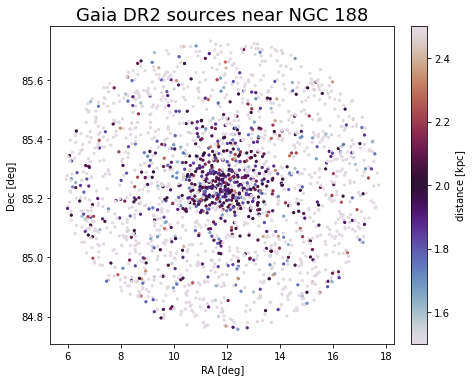

In [29]:
fig, ax = plt.subplots(figsize=(6.5, 5.2),
                       constrained_layout=True)
cs = ax.scatter(ngc188_coords_3d.ra.degree, 
                ngc188_coords_3d.dec.degree, 
                c=ngc188_coords_3d.distance.kpc, 
                s=5, vmin=1.5, vmax=2.5, cmap='twilight')
cb = fig.colorbar(cs)
cb.set_label(f'distance [{u.kpc:latex_inline}]')

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_title('Gaia DR2 sources near NGC 188', fontsize=18)

Now that we have 3D position information for both the cluster center, and for the stars we queried from *Gaia*, we can compute the 3D separation (distance) between all of the *Gaia* sources and the cluster center:

In [30]:
sep3d = ngc188_coords_3d.separation_3d(ngc188_center_3d)
sep3d

<Distance [ 227.6639131 ,  152.12131824,    7.58348148, ...,  827.32319151,
           1801.21747162,  192.85899356] pc>

### Exercises

Using the 3D separation values, define a boolean mask to select candidate members of the cluster. Select all stars within 50 pc of the cluster center. How many candidate members of NGC 188 do we have, based on their 3D positions?

In [31]:
ngc188_3d_mask = sep3d < 50*u.pc
ngc188_3d_mask.sum()

191

In this tutorial, we have introduced `astropy.coordinates` as a way to store and represent astronomical sky coordinates. We used coordinate objects, via the `SkyCoord` class interface, to parse and change coordinate representations and units. We also demonstrated how to use a `SkyCoord` object with the `astroquery` package to query an astronomical database, the *Gaia* science archive. We then created a single `SkyCoord` object with the queried data that represents the sky coordinates of many objects. Finally, we introduced the concept of using `astropy.coordinates` to represent a 3D position of an object or set of objects.